緯度 35.85189541368357 経度 139.59914390936336 での基準高さ: 5.5 m
緯度 35.85189541368357 度での重力加速度: 9.798065 m/s²
/content
T0: 295.97999999999996 K
P1: 1004.12 hPa
Minimum Pressure: 997.36 hPa
Hの最大値: 64.03013966595294 m, 時間: 150.0 s
1行目の高さ: 6.018093220396063 m
最大差分: 58.012046445556884 m


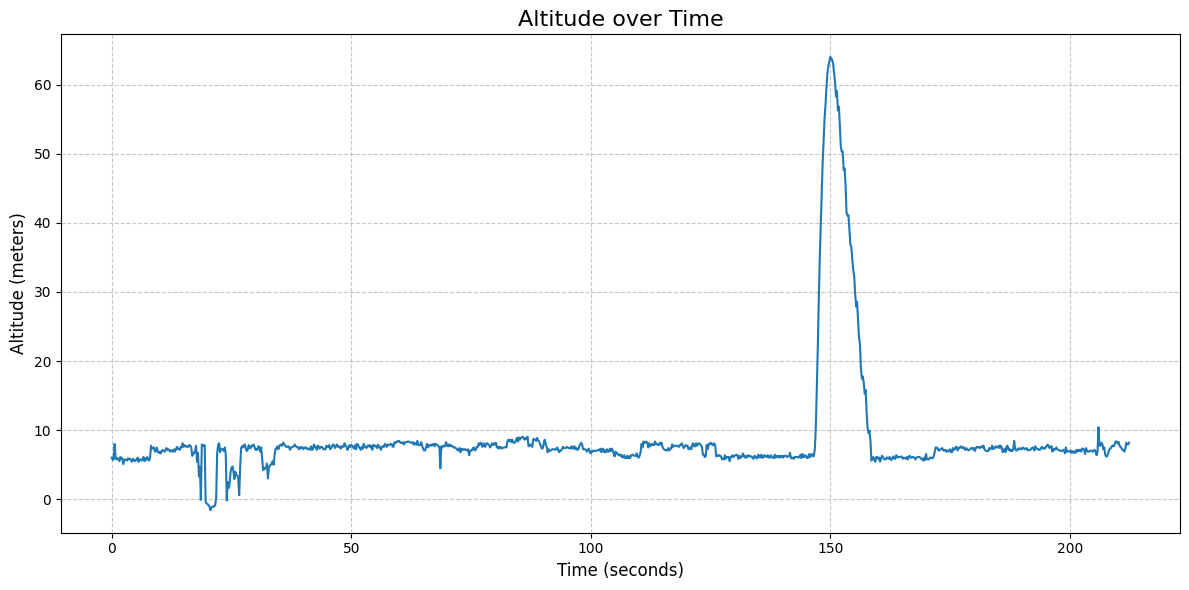

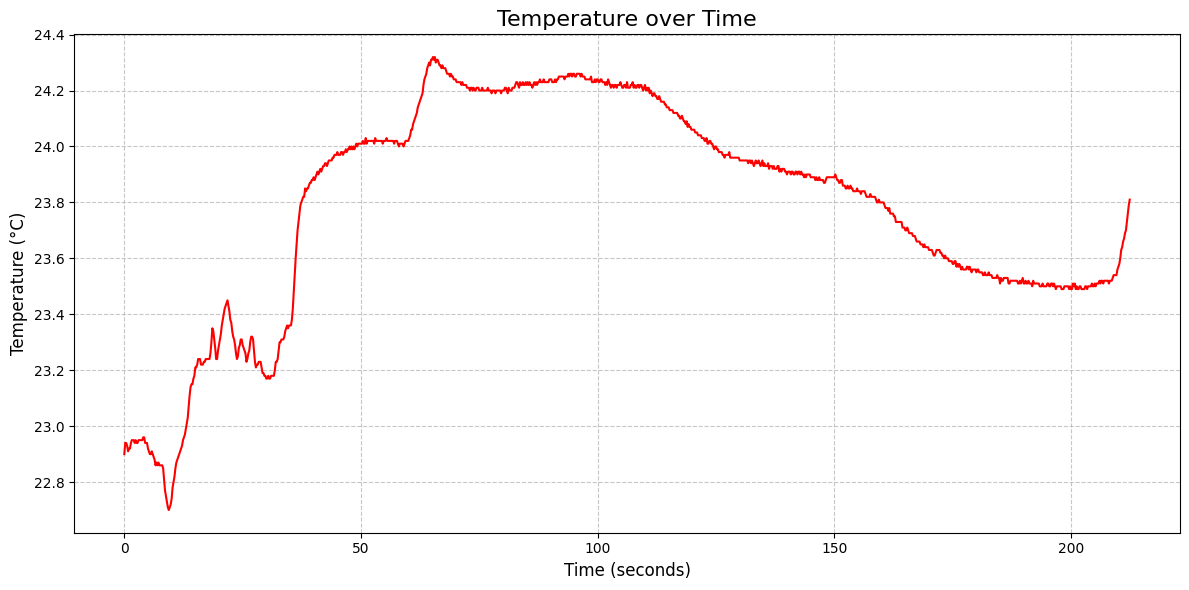

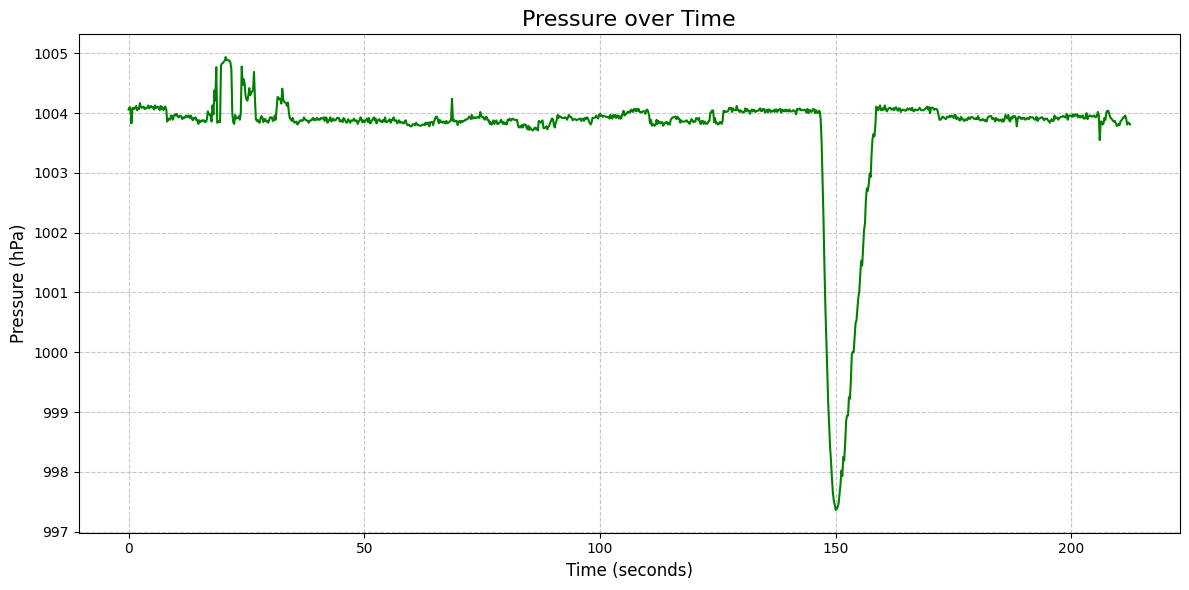

Maximum Temperature Difference: 1.42 °C
Minimum Temperature Difference: -0.20 °C


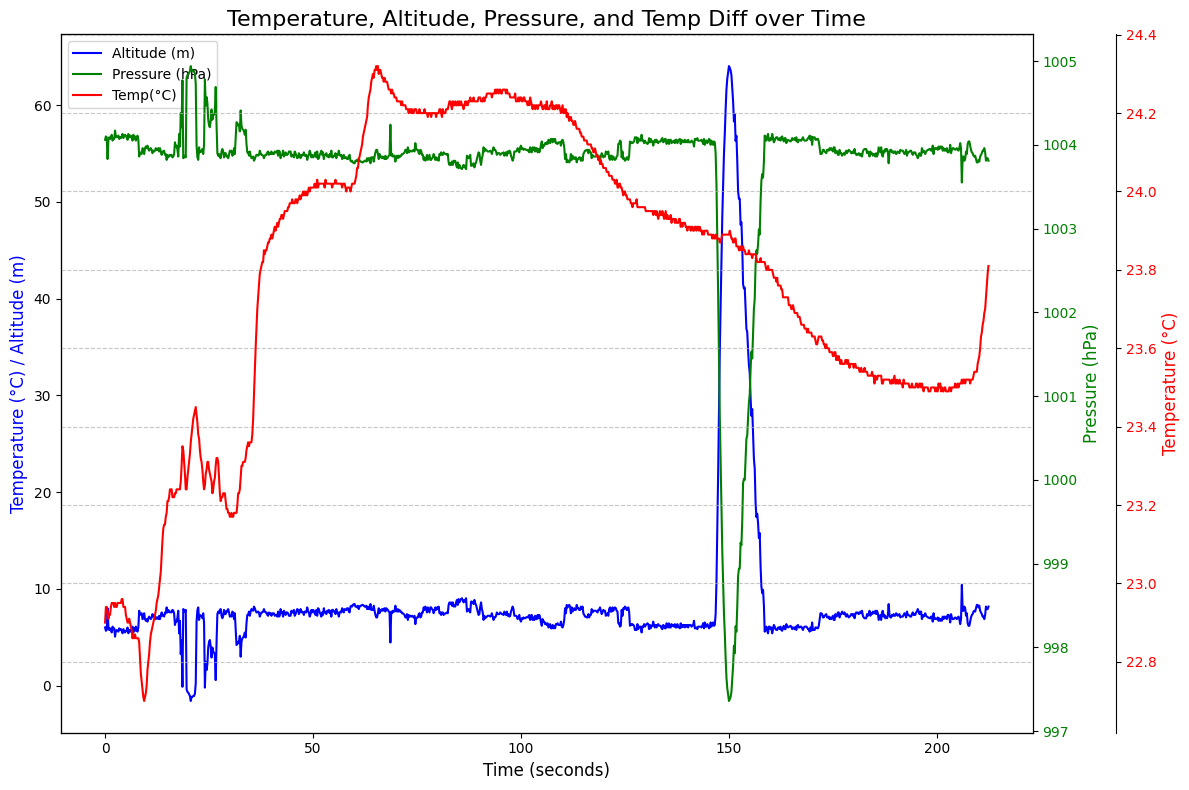

In [37]:
import pandas as pd
import os
import math
import requests
import json
import time
import matplotlib.pyplot as plt

def get_local_elevation(lat, lon):
    url = f"http://cyberjapandata2.gsi.go.jp/general/dem/scripts/getelevation.php?lon={lon}&lat={lat}&outtype=JSON"
    try:
        response = requests.get(url)
        response.raise_for_status()
        elevation_data = json.loads(response.text)
        elevation = elevation_data['elevation']
        return elevation
    except requests.RequestException as e:
        print(f"エラー: データの取得に失敗しました - {e}")
        return None
    except (KeyError, json.JSONDecodeError) as e:
        print(f"エラー: データの解析に失敗しました - {e}")
        return None

def calculate_gravity(latitude):
    phi = math.radians(latitude)
    g = 9.780327 * (1 + 0.0053024 * math.sin(phi)**2 - 0.0000058 * math.sin(2 * phi)**2)
    return g

# 定数
L = -0.0065 # 気温減率
M = 0.0289644 # 大気のモル質量
R = 8.31432 # 気体定数


# 緯度と経度の設定
latitude = 35.49840809627241 #打上場所の緯度（二和：36.1416，横浜サイエンス：35.49840809627241, 秋ヶ瀬：35.85189541368357）
longitude = 139.67827233958394 #打上場所の経度（二和：140.0110，横浜サイエンス：139.67827233958394, 秋ヶ瀬：139.59914390936336）

# 重力加速度の計算
g = calculate_gravity(latitude) # 重力加速度の計算
H1 = get_local_elevation(latitude, longitude) # 打上場所の標高

print(f"緯度 {latitude} 経度 {longitude} での基準高さ: {H1} m")
print(f"緯度 {latitude} 度での重力加速度: {g:.6f} m/s²")

# データの読み込みと処理
print(os.getcwd())

with open('ALTLOG20241130_1456_akigase.TXT', 'r') as file:
    lines = file.readlines()

# 3行目からP1を求める
P1 = None
for i, line in enumerate(lines[:3], 1):
    if 'Pressure' in line:
        P1 = float(line.split(' = ')[1].split()[0])
        break

if P1 is None:
    raise ValueError("Pressure value not found in the first 3 lines of the file")

# 2行目から温度を取得してT0を設定（ケルビン）
T0 = None
for i, line in enumerate(lines[1:3], 1):  # 2行目から温度を探す
    if 'Temperature' in line:
        T0 = float(line.split(' = ')[1].split()[0]) + 273.15  # セルシウスからケルビンに変換
        break

if T0 is None:
    raise ValueError("Temperature value not found in the specified lines of the file")

print(f"T0: {T0} K")
print(f"P1: {P1} hPa")

records = []
current_record = {}

for line in lines[3:]:  # 4行目から開始
    line = line.strip()
    if not line:
        if current_record:
            records.append(current_record)
            current_record = {}
        continue

    try:
        key, value = line.split(' = ')
        if key == 'VBat':
            current_record['VBat'] = float(value)
        elif key == 'Temperature':
            current_record['Temperature'] = float(value.split()[0])
        elif key == 'Pressure':
            current_record['Pressure'] = float(value.split()[0])

    except ValueError:
        print(f"Skipping invalid line: {line}")

if current_record:
    records.append(current_record)

df = pd.DataFrame(records)

def calculate_H(row, PQ):
    P = row['Pressure']
    return ((T0 * (P / PQ) ** ((-1) * (R * L) / (g * M))) - T0) / L

# PQの計算（一度だけ計算）
PQ = P1 * ((T0 + L * H1) / T0) ** (g * M / (R * L))
df['H'] = df.apply(lambda row: calculate_H(row, PQ), axis=1)
df['Time'] = [i * 0.2 for i in range(len(df))]

# Hの最大値とその位置を求める
max_H_value = df['H'].max()
max_H_index = df['H'].idxmax()
max_H_time = df['Time'][max_H_index]

# 1行目のHとの最大差分を計算
first_H_value = df['H'].iloc[0]
max_difference = max_H_value - first_H_value

# Find the minimum pressure value
min_pressure_value = df['Pressure'].min()

# Print the minimum pressure
print(f"Minimum Pressure: {min_pressure_value} hPa")

# 結果を表示
print(f"Hの最大値: {max_H_value} m, 時間: {max_H_time} s")
print(f"1行目の高さ: {first_H_value} m")
print(f"最大差分: {max_difference} m")

# グラフ作成
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['H'])
plt.title('Altitude over Time', fontsize=16)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Altitude (meters)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
# PNGファイルとして保存
plt.savefig('altitude_over_time.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


# グラフ作成 (Temperature)
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['Temperature'], color='red')
plt.title('Temperature over Time', fontsize=16)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('temperature_over_time.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


# グラフ作成 (Pressure)
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['Pressure'], color='green')
plt.title('Pressure over Time', fontsize=16)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Pressure (hPa)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('pressure_over_time.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()



# Temperature Difference Analysis
df['Temperature_Difference'] = df['Temperature'] - df['Temperature'].iloc[0]
max_temp_diff = df['Temperature_Difference'].max()
min_temp_diff = df['Temperature_Difference'].min()
print(f"Maximum Temperature Difference: {max_temp_diff:.2f} °C")
print(f"Minimum Temperature Difference: {min_temp_diff:.2f} °C")

# Combined plot with Temperature, Altitude, and Pressure on separate y-axes
plt.figure(figsize=(12, 8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))

ax1.plot(df['Time'], df['H'], label='Altitude (m)', color='blue')
ax2.plot(df['Time'], df['Pressure'], label='Pressure (hPa)', color='green')
ax3.plot(df['Time'], df['Temperature'], label='Temp(°C)', color='red')

plt.title('Temperature, Altitude, Pressure over Time', fontsize=16)
ax1.set_xlabel('Time (seconds)', fontsize=12)
ax1.set_ylabel('Temperature (°C) / Altitude (m)', fontsize=12, color='blue')
ax2.set_ylabel('Pressure (hPa)', fontsize=12, color='green')
ax3.set_ylabel('Temperature (°C)', fontsize=12, color='red')

ax2.tick_params(axis='y', labelcolor='green')
ax3.tick_params(axis='y', labelcolor='red')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('combined_plot_with_temp_diff.png', dpi=300, bbox_inches='tight')
plt.show()